In [163]:
import numpy as np
import pickle as pkl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from aidam.miscellanea_utils import find_matlabstyle

import seaborn as sns

from aidam.faga.curve_fit import FagaCurveFit

from aidam.math_utils import moving_function_rev1
from aidam.NbEnhance import tabprint

## Lettura dati

In [164]:
data_file='stored_data.pkl'

infile=open(data_file,'rb')
trend=pkl.load(infile)
regioni=pkl.load(infile)
giorni=pkl.load(infile)
giorno_settimana=pkl.load(infile)
infile.close()

day_counter=list(range(len(giorni)))

print('Giorni osservati: %d'%len(giorni))
print('Primo giorno: %s'%giorni[0])
print('Ultimo giorno: %s'%giorni[-1])

Giorni osservati: 213
Primo giorno: 2020-02-24T18:00:00
Ultimo giorno: 2020-09-23T17:00:00


Preparazione date

- creo il giorno 0 nel formato *datetime* per poi creare i nuovi plot su questa base
- creo una lista di giorni (in formato di stringhe) partendo dal giorno0

In [165]:
giorno0=datetime.strptime(giorni[0][0:10], "%Y-%m-%d")
str_giorni=[]
for d in range(500):
    str_giorni.append((giorno0+timedelta(d)).strftime("%Y-%m-%d"))
str_giorni=np.array(str_giorni)

oggi=datetime.strftime(datetime.now(), "%Y-%m-%d")
indice_oggi=find_matlabstyle(str_giorni,lambda x:x==oggi)[0]

## Funzioni base

Si testano due versioni generalizzate della sigmoide:

- sigmoide generalizzata
- sigmoide generalizzata estesa

In [166]:
def generalized_sigmoid(t,a,b,M,alpha):
    y=M/(1+np.exp(-a*t+b))**alpha
    return y

def generalized_sigmoid_ext(t,a,b,c,M,alpha):
    y=(M+c*t)/(1+np.exp(-a*t+b))**alpha
    return y


def two_waves_generalized_sigmoids_ext(t,t_sw,a1,b1,c1,M1,alpha1,a2,b2,c2,M2,alpha2):    
    if t<=t_sw:
        y=(M1+c1*t)/(1+np.exp(-a1*t+b1))**alpha1
    else:
        #y=(M1+c1*t)/(1+np.exp(-a1*t+b1))**alpha1+(M2+c2*t)/(1+np.exp(-a2*(t-t_sw)+b2))**alpha2
        y=(M1+c1*t)/(1+np.exp(-a1*t+b1))**alpha1+(M2+c2*(t-t_sw))/(1+np.exp(-a2*(t-t_sw)+b2))**alpha2-(M2)/(1+np.exp(b2))**alpha2
    return y


def two_waves_generalized_sigmoids(t,t_sw,a1,b1,M1,alpha1,a2,b2,M2,alpha2):
    t_sw=np.round(t_sw)
    if t<t_sw:
        y=(M1)/(1+np.exp(-a1*t+b1))**alpha1    
    else:        
        y=(M1)/(1+np.exp(-a1*t+b1))**alpha1+(M2)/(1+np.exp(-a2*(t-t_sw+1)+b2))**alpha2-(M2)/(1+np.exp(b2))**alpha2
    return y



employed_model=two_waves_generalized_sigmoids

## Nuovi positivi *normalizzati*

In [167]:
from scipy.signal import savgol_filter
trend['perc_tamponi_positivi']['Italia'][0]=trend['perc_tamponi_positivi']['Italia'][1]

np_it=trend['nuovi_positivi']['Italia']


nwt=7
nwp=3


norm_np_it=0.01*np.multiply(moving_function_rev1(trend['tamponi_giornalieri']['Italia'],np.median,nwt,nwt),
                     moving_function_rev1(trend['perc_tamponi_positivi']['Italia'],np.mean,nwp,nwp))

norm_np_it=savgol_filter(norm_np_it,9,1)

### Test plots

## Fitting

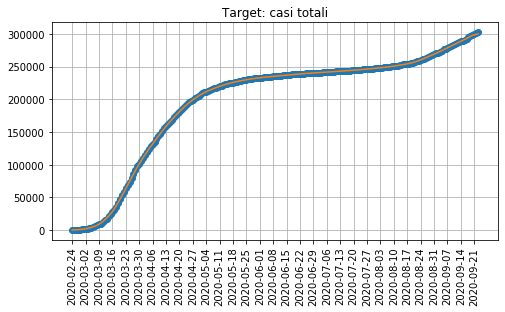

In [168]:
#target_data=trend['totale_casi']['Italia']
target_data=np.cumsum(trend['nuovi_positivi']['Italia'])
#target_data=np.cumsum(norm_np_it)
target_data_filtered=moving_function_rev1(target_data,np.mean,3,3)

fig,ax=plt.subplots(1,1,figsize=(8,4))
ax.plot(day_counter,target_data,'o')
ax.plot(day_counter,target_data_filtered,'-')
ax.set_xticks(list(range(0,len(target_data),7)))
ax.set_title('Target: casi totali')
ax.set_xticklabels(str_giorni[list(range(0,len(target_data),7))],rotation=90)
ax.grid()

## GA-based Curve fitting

E' possibile utilizzare solo **parzialmente** i dati per il tuning del modello: tramite il parametro `days_training` si decide quanti giorni usare effettivamente dall'inizio del dataset


In [169]:
days_training=len(target_data)-21

# Italia
a_range=[0,0.3]
b_range=[0, 0.4]
c_range=[0,10]
M_range=[2e+5,3e+5]
alpha_range=[0,10]
t_sw_range=[115,130]

'''
# dominio per generalized_sigmoid_ext
dominio=np.vstack((a_range,
                   b_range,
                   c_range,
                   M_range,
                   alpha_range))
'''



# dominio per two_waves_generalized_sigmoids_ext
#M_range=[0,3e+5]
dominio=np.vstack((t_sw_range,
                   a_range,
                   b_range,
                   c_range,
                   M_range,
                   alpha_range,
                   a_range,
                   b_range,
                   c_range,
                   M_range,
                   alpha_range))


# dominio per two_waves_generalized_sigmoids
#M_range=[0,3e+5]
dominio=np.vstack((t_sw_range,
                   a_range,
                   b_range,
                   M_range,
                   alpha_range,
                   a_range,
                   b_range,
                   M_range,
                   alpha_range))

                   
dominio=dominio.T

tabprint(dominio,digits=10,precision=1,index=['Min','Max'])

            0         1         2         3         4         5         6         7         8
         ----      ----      ----      ----      ----      ----      ----      ----      ----
Min     115.0       0.0       0.0  200000.0       0.0       0.0       0.0  200000.0       0.0
Max     130.0       0.3       0.4  300000.0      10.0       0.3       0.4  300000.0      10.0


In [170]:
def error_measure(predicted,actual):
    #return np.mean(np.abs(predicted-actual))+np.std(np.abs(predicted-actual))
    return 0.7*np.mean(np.abs(predicted-actual))+0.3*np.mean(np.abs(predicted[-14:]-actual[-14:]))
    #return 0.2*np.percentile(np.abs(predicted-actual),5)+np.mean(np.abs(predicted-actual))
    #return np.mean(np.abs(predicted-actual))

np.random.seed(42)
    
fct=FagaCurveFit()

fct.fit(employed_model, 
        np.arange(days_training),
        target_data[0:days_training],
        dominio,
        ga_generations=1500, ga_population=30,print_info=100,
        error_function=error_measure,
        num_mutations=1)



Welcome to FagaCurveFit!
Gen:     0 BestAll: 2.258 BestGen: 2.258  BioDiv: 6e+03
Gen:   100 BestAll: 16.19 BestGen: 16.19  AveFit: 13.55
Gen:   200 BestAll: 24.81 BestGen: 24.81  AveFit: 22.39
Gen:   300 BestAll: 27.3 BestGen: 27.3  AveFit: 22.98
Gen:   400 BestAll: 29.13 BestGen: 29.13  AveFit: 26.16
Gen:   500 BestAll: 30.52 BestGen: 30.52  AveFit: 28.2
Gen:   600 BestAll: 34.6 BestGen: 34.6  AveFit: 31.55
Gen:   700 BestAll: 38.21 BestGen: 38.21  AveFit: 32.12
Gen:   800 BestAll: 39.73 BestGen: 39.73  AveFit: 36.72
Gen:   900 BestAll: 40.15 BestGen: 40.15  AveFit: 36.95
Gen:  1000 BestAll: 40.25 BestGen: 40.25  AveFit: 37.21
Gen:  1100 BestAll: 42.04 BestGen: 42.04  AveFit: 38.32
Gen:  1200 BestAll: 42.36 BestGen: 42.36  AveFit: 38.98
Gen:  1300 BestAll: 43.23 BestGen: 43.23  AveFit: 39.37
Gen:  1400 BestAll: 43.79 BestGen: 43.79  AveFit: 41.35
Gen:  1500 BestAll: 45.24 BestGen: 45.24  AveFit: 41.54


In [171]:
solution=fct.opt_params

print('\nOptimal solution is: ')

print(solution)
# Interpretazione della soluzione
print('Inizio second wave: giorno %d, %s'%(solution[0],giorni[int(np.round(solution[0]))]))



Optimal solution is: 
[1.24193939e+02 6.35938830e-02 2.57938766e-01 2.37081856e+05
 7.08237049e+00 2.49683700e-02 3.41525987e-01 2.07578363e+05
 7.76825635e+00]
Inizio second wave: giorno 124, 2020-06-27T17:00:00


Text(0.5, 0.98, 'Fitness trends')

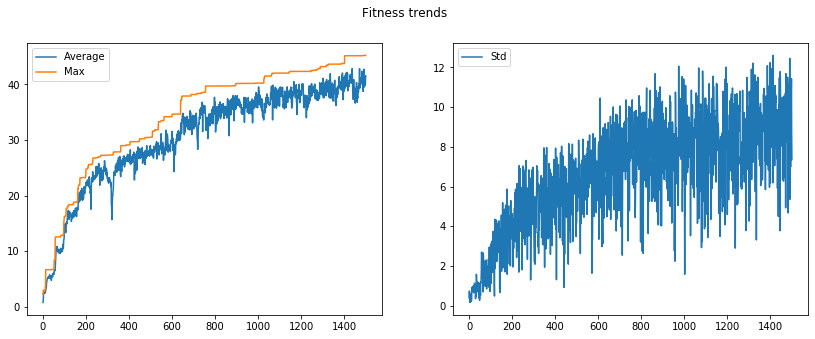

In [172]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
ax[0].plot(fct.fitness_tracker['average'],label='Average')
ax[0].plot(fct.fitness_tracker['max'],label='Max')
ax[0].legend()
ax[1].plot(fct.fitness_tracker['std'],label='Std')
ax[1].legend()
fig.suptitle('Fitness trends')


Adesso applico il modello tunato sia ai giorni passati sia a giorni futuri.

*forecast_days* sono i giorni per cui lo applico: iniziano dal giorno 0 e finoscono quando si vuole nel futuro

In [173]:
forecast_days=np.arange(300)
y_pred=np.array(list(map(lambda x:employed_model(x,*solution),forecast_days)))

#### Plots

C:\Users\klaat\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



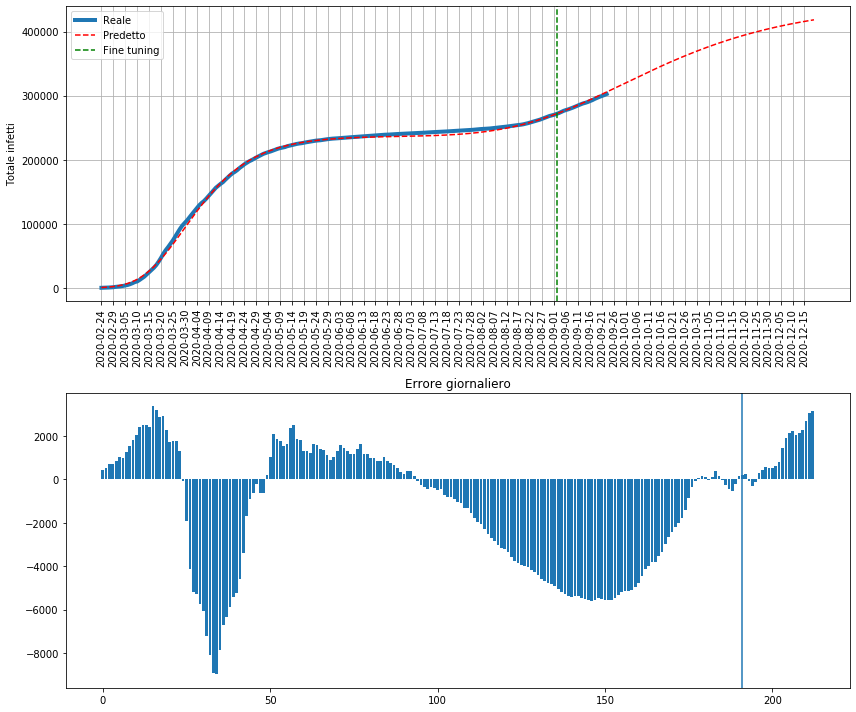

In [174]:
# preparazione palette colori
lista_colori=list(mcolors.TABLEAU_COLORS.items())
color_names=[cn[0] for cn in lista_colori]

fig,ax=plt.subplots(2,1,figsize=(12,10))
ax[0].plot(day_counter,target_data,label='Reale',linewidth=4)
ax[0].plot(forecast_days,y_pred,'r--',label='Predetto')
ax[0].axvline(days_training-1,c='g',ls='--',label='Fine tuning')
ax[0].set_xticks(list(range(0,len(forecast_days),5)))
ax[0].set_xticklabels(str_giorni[list(range(0,len(forecast_days),5))],rotation=90)
ax[0].set_ylabel('Totale infetti')
ax[0].legend()
ax[0].grid()

ax[1].bar(day_counter,y_pred[day_counter]-target_data)
ax[1].axvline(days_training-1)
ax[1].set_title('Errore giornaliero')
fig.tight_layout()
fig.show()

### Adesso vediamo, secondo il modello, quando non avremo più contagiati

In [175]:
nuovi_contagi_pred=np.diff(y_pred)

nuovi_contagi_reali=np.diff(target_data)
nuovi_contagi_reali_filtered=moving_function_rev1(nuovi_contagi_reali,np.mean,3,3)#np.diff(target_data_filtered)

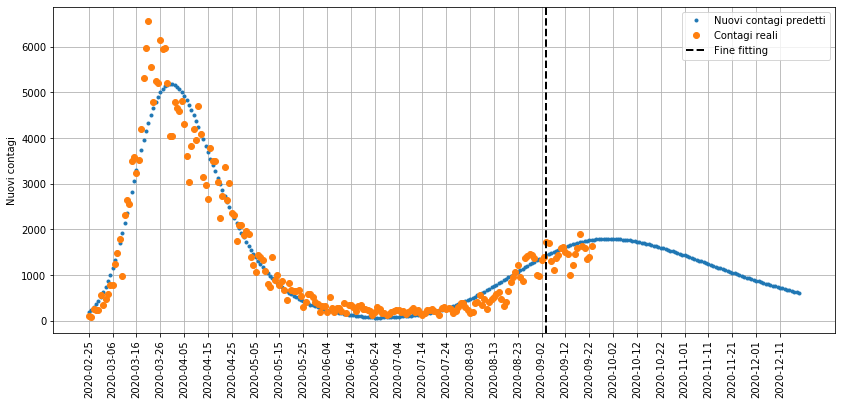

In [181]:
fig,ax=plt.subplots(1,1,figsize=(14,6))
ax.plot(nuovi_contagi_pred,'.',label='Nuovi contagi predetti')
ax.set_ylabel('Nuovi contagi')

ax.plot(nuovi_contagi_reali,'o',label='Contagi reali')
#ax.plot(nuovi_contagi_reali_filtered,'+',label='Contagi reali filt.')
ax.axvline(x=days_training,linewidth=2, color='k',linestyle='--',label='Fine fitting')
    
ax.set_xticks(list(range(0,len(forecast_days),10)))
ax.set_xticklabels(str_giorni[list(range(1,len(forecast_days),10))],rotation=90)
ax.grid()
ax.legend()


In [178]:
import plotly.graph_objects as go

In [179]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=day_counter,
                         y=nuovi_contagi_reali,
                         mode='markers',
                         name='Reali'))
fig.add_trace(go.Scatter(x=day_counter,
                         y=nuovi_contagi_pred,
                         mode='lines',
                         name='Predetti'))
fig.add_trace(go.Scatter(x=day_counter,
                         y=nuovi_contagi_reali_filtered,
                         mode='markers',
                         name='Reali filtrati'))
fig.update_layout(title='Nuovi contagi',
                  xaxis_tickmode = 'array',
                  xaxis_tickvals = np.arange(0,len(day_counter),7),
                  xaxis_ticktext = [g[0:10] for g in giorni[np.arange(0,len(day_counter),7)]])
fig.show()

C:\Users\klaat\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



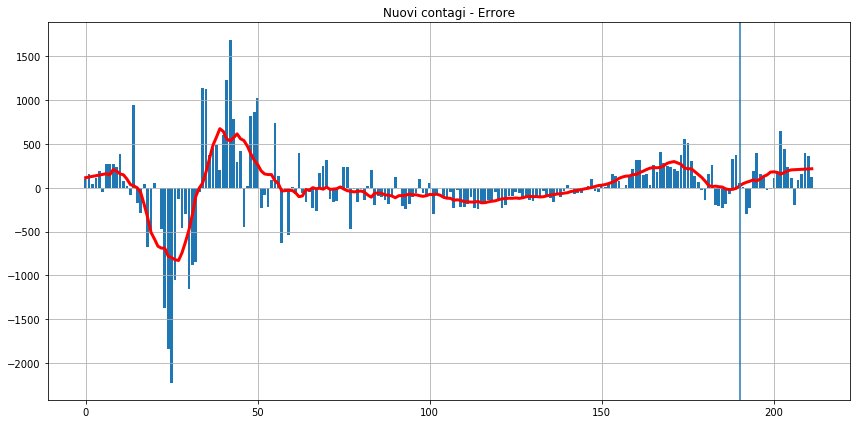

In [180]:
from scipy.signal import savgol_filter


fig,ax=plt.subplots(1,1,figsize=(12,6))
errore_giornaliero=nuovi_contagi_pred[0:len(nuovi_contagi_reali)]-nuovi_contagi_reali
ax.bar(day_counter[0:len(nuovi_contagi_reali)],errore_giornaliero)
#ax.plot(day_counter[0:len(nuovi_contagi_reali)],moving_function_rev1(errore_giornaliero,np.mean,5,2),'r',linewidth=3)
ax.plot(day_counter[0:len(nuovi_contagi_reali)],savgol_filter(errore_giornaliero,13,1),'r',linewidth=3)
ax.axvline(days_training-2)
ax.set_title('Nuovi contagi - Errore')
ax.grid()
fig.tight_layout()
fig.show()